In [ ]:
import sys
import os
os.environ["http_proxy"] = "http://localhost:8890"
os.environ["https_proxy"] = "http://localhost:8890"
print(os.environ['https_proxy'])
sys.path.append('/data/zhicai/code/da-fusion/')

## Transformers

In [ ]:
from semantic_aug.datasets.cub import CUBBirdHugDataset
ds_train = CUBBirdHugDataset(split='train', crop_size=254, image_size=224)
input_image = ds_train[0]['pixel_values'].unsqueeze(0)
outputs = clip_classifier(input_image, return_dict=True)


In [ ]:
outputs

In [ ]:
import gdown
from transformers import AutoImageProcessor, ResNetForImageClassification
import torch
from datasets import loaddataset

dataset = loaddataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

inputs = processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

url = 'https://drive.google.com/uc?id=1skwblH1_okBwxWxmRsp9_qi15hyPpxg8'
gdown.download(url, 'VLCS.tar.gz', quiet=False)

In [ ]:
import copy
from diffusers import StableDiffusionImg2ImgPipeline, StableDiffusionPipeline
from diffusers import UNet2DConditionModel
from diffusers.models.attention_processor import LoRAAttnProcessor
import torch

unet_lora = torch.load(
    '../outputs/finetune_model/finetune_db/sd-cub-model-lora/checkpoint-9000/pytorch_model.bin')

pipe = StableDiffusionPipeline.from_pretrained(
    'CompVis/stable-diffusion-v1-4', torch_dtype=torch.float16).to('cuda:0')
unet = pipe.unet
lora_attn_procs = {}
for name in unet.attn_processors.keys():
    cross_attention_dim = None if name.endswith(
        "attn1.processor") else unet.config.cross_attention_dim
    if name.startswith("mid_block"):
        hidden_size = unet.config.block_out_channels[-1]
    elif name.startswith("up_blocks"):
        block_id = int(name[len("up_blocks.")])
        hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
    elif name.startswith("down_blocks"):
        block_id = int(name[len("down_blocks.")])
        hidden_size = unet.config.block_out_channels[block_id]

    lora_attn_procs[name] = LoRAAttnProcessor(
        hidden_size=hidden_size,
        cross_attention_dim=cross_attention_dim,
        rank=10,
    )
unet.set_attn_processor(lora_attn_procs)
new_state_dict = copy.deepcopy(pipe.unet.state_dict())
new_state_dict.update(unet_lora)
pipe.unet.load_state_dict(new_state_dict)

In [ ]:
pipe.load_lora_weights(
    '../outputs/finetune_model/finetune_db/sd-cub-model-lora/pytorch_lora_weights.safetensors')

## Dataset

In [ ]:
from datasets import ClassLabel
filtered_train = train_ds.filter(lambda x: x['label'] in small_set)
filtered_test = test_ds.filter(lambda x: x['label'] in small_set)
original_int2str = filtered_train.features['label'].int2str
original_str2int = filtered_train.features['label'].str2int
new_label_feature = ClassLabel(num_classes=len(small_set), names=[
                               original_int2str(i) for i in small_set])
new_str2int = new_label_feature.str2int
filtered_train = filtered_train.map(
    lambda x: {'label': new_str2int(original_int2str(x['label']))})
filtered_test = filtered_test.map(
    lambda x: {'label': new_str2int(original_int2str(x['label']))})
filtered_train = filtered_train.cast_column('label', new_label_feature)
filtered_test = filtered_test.cast_column('label', new_label_feature)
filtered_train.save_to_disk(
    '/data/zhicai/cache/huggingface/local/CUB_small_train')
filtered_test.save_to_disk(
    '/data/zhicai/cache/huggingface/local/CUB_small_test')

In [ ]:
import os

out = '/data/zhicai/code/da-fusion/outputs/aug_samples/cub/dreambooth-lora-augmentation-Multi5-Strength0.02'
rootdir = os.path.join(out, 'data')
# 正则表达式模式来匹配路径中的各个部分
pattern_level_1 = r"(.+)"
pattern_level_2 = r"(.+)-(\d+)-(\d+\.\d+).png"

data_dict = defaultdict(list)
for dir in os.listdir(rootdir):
    if not os.path.isdir(os.path.join(rootdir, dir)):
        continue
    match_1 = re.match(pattern_level_1, dir)
    first_dir = match_1.group(1).replace("_", " ")
    for file in os.listdir(os.path.join(rootdir, dir)):
        match_2 = re.match(pattern_level_2, file)
        second_dir = match_2.group(1).replace("_", " ")
        num = int(match_2.group(2))
        floating_num = float(match_2.group(3))
        data_dict['First Directory'].append(first_dir)
        data_dict['Second Directory'].append(second_dir)
        data_dict['Number'].append(num)
        data_dict['Strength'].append(floating_num)
        data_dict['Path'].append(os.path.join(dir, file))

df = pd.DataFrame(data_dict)
# save df as csv
csv_path = os.path.join(out, 'meta.csv')
df.to_csv(csv_path, index=False)

## Evaluation

In [ ]:
import torch
from torch.utils.data import DataLoader

# forward pass
device = 'cuda:0'
gt_labels = []
pred_logits = []
batch_size = 16  # 设置批大小
data_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False)
model = model.to(device)
with torch.no_grad():
    for batch in data_loader:
        pixel_values = batch['pixel_values'].to(device)
        gt_label = batch['label']
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits
        gt_labels.append(gt_label)
        pred_logits.append(logits)
        
# gt_labels = torch.cat(gt_labels)
import numpy as np
import matplotlib.pyplot as plt
from base.utils import calculate_accuracy, calculate_confusion_matrix
pred_logits = torch.cat(pred_logits).detach().cpu()
gt_labels = torch.cat(gt_labels)
acc = calculate_accuracy(pred_logits, gt_labels)
print('accuracy:', acc)

conf_matrix = calculate_confusion_matrix(pred_logits, gt_labels)
plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix[:100, :100])
# plt.savefig('conf_matrix_cub_baseline.jpg')

np.save('confusion-matrix.npy', conf_matrix)

In [ ]:
num_classes = 200
options = list(zip(range(num_classes), range(num_classes)))
options

options = []
topk = 5
topk_indices = np.argsort(-conf_matrix, axis=1)[:, :(topk+1)]
# for i in range(len(topk_indices)):
#     indices = topk_indices[i]
#     source_label = indices[0]
#     target_labels = indices[1:]
#     options.extend([(source_label, target_label) for target_label in target_labels])

### Softlabel annotated by baseline classifier

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
root_path = '/data/zhicai/code/da-fusion/outputs/aug_samples/tiny-bird-db_lora/data'
meta_df = pd.read_csv(
    '/data/zhicai/code/da-fusion/outputs/aug_samples/tiny-bird-db_lora/meta.csv')

meta_df = meta_df[(meta_df['First Directory'] == 'American Goldfinch') & (
    meta_df['Second Directory'] == 'Shiny Cowbird') & (meta_df['Number'] == 0)]

meta_df = meta_df.sort_values(by='Strength')
img_paths = meta_df['Path'].values
strengths = meta_df['Strength'].values
targets = meta_df['Second Directory'].values
predicts = []
for path in img_paths:
    img = Image.open(os.path.join(root_path, path)).convert('RGB')
    img = val_transforms(img)
    pixel_values = img.unsqueeze(0)
    outputs = model(pixel_values=pixel_values)
    predicts.append(outputs.logits)
    # break
len(predicts)
source_label = ds_test.class2label['American Goldfinch']
target_label = ds_test.class2label['Shiny Cowbird']
s_logits = []
t_logits = []
for logits in predicts:
    s_logits.append(logits[:, source_label].item())
    t_logits.append(logits[:, target_label].item())


plt.plot(strengths, s_logits, label='American Goldfinch')
plt.plot(strengths, t_logits, label='Shiny Cowbird')
plt.legend()
plt.show()

In [ ]:
import torch
from PIL import Image
root_path = '/data/zhicai/code/da-fusion/outputs/aug_samples/tiny-bird-db_lora/data'
meta_df = pd.read_csv(
    '/data/zhicai/code/da-fusion/outputs/aug_samples/tiny-bird-db_lora/meta.csv')

meta_df = meta_df[(meta_df['First Directory'] == 'American Goldfinch') & (
    meta_df['Second Directory'] == 'Shiny Cowbird') & (meta_df['Number'] == 0)]

meta_df = meta_df.sort_values(by='Strength')
img_paths = meta_df['Path'].values
strengths = meta_df['Strength'].values
targets = meta_df['Second Directory'].values
predicts = []
for path in img_paths:
    img = Image.open(os.path.join(root_path, path)).convert('RGB')
    img = val_transforms(img)
    pixel_values = img.unsqueeze(0)
    outputs = model(pixel_values=pixel_values)
    predicts.append(outputs.logits)

print(' Source: American Goldfinch\n', 'Target:',
      targets[idx], '\n', 'Strength:', strengths[idx], '\n')
topk_indices = torch.topk(logits, k=5, dim=-1)[-1].squeeze()
for indice in topk_indices:
    print(ds_test.label2class[indice.item()], logits[:, indice].item())

## Others

### Beta distribution

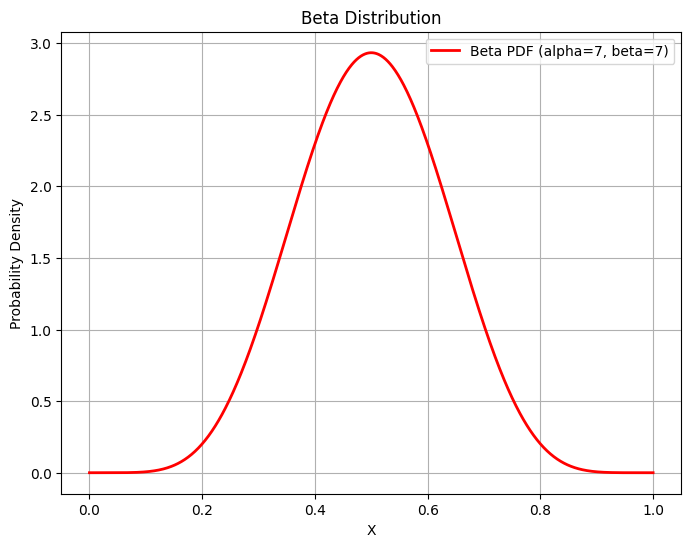

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# 超参数 (alpha 和 beta)
np.random.seed(0)
alpha = 7
beta_param = 7
# np.random.beta(alpha,beta_param)

# 生成 Beta 分布的样本点
x = np.linspace(0, 1, 1000)
pdf = beta.pdf(x, alpha, beta_param)

# 绘制 Beta 分布
plt.figure(figsize=(8, 6))
plt.plot(x, pdf, 'r-', lw=2,
         label='Beta PDF (alpha={}, beta={})'.format(alpha, beta_param))
plt.title('Beta Distribution')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df2 = df.where((df['Strength'] >= 0.5) & (df['Strength'] <= 0.9)).dropna()
len(df2)

In [ ]:
from huggingface_hub import try_to_load_from_cache, _CACHED_NO_EXIST
from transformers import AutoConfig, AutoModelForImageClassification

filepath = try_to_load_from_cache('microsoft/resnet-50','config.json')
if isinstance(filepath, str):
    # file exists and is cached
    print(filepath)
elif filepath is _CACHED_NO_EXIST:
    print("Not cached")
else:
    print("????")
